# ДЗ №10 Imbalanced Binary Classification
Добавлено: 23.10.2021 14:12
Сдать до 17 января 17:00

- Перед вами стоит задача по информации о банковской транзакции определить мошенническая она или нет. 
- В архиве будут 2 csv файла, нужно попытаться использовать оба для предсказаний. 
- Целевая колонка isFraud в файле trans_small.csv.

Задание:
* Сделать анализ данных (пустые значения, категориальные данные)
* Проверить баланс классов
* Разбить датасет на train/test (stratified)
* Сделать базовую модель (например лог регрессию)
* Использовать KNN (попробовать поменять параметр k)
* Использовать Gradient Boosting (любой из XGBoost, LGBM, CatBoost)
* Задать параметр class_weight для градиентного бустинга.
* Попробовать уравнять классы (random undersampling)

Опционально:
* Попробовать SMOTE из библиотеки imbalance-learn

Как метрику использовать AUC
fraud_detection.7z

# Import section

In [167]:
# Base library
import numpy as np                                        # Linear algebra
import pandas as pd                                       # Data processing

# Visualization library
import matplotlib.pyplot as plt                           # Plotting library 
import seaborn as sns                                     # Data visualization

# Displays output inline
%matplotlib inline     

In [168]:
# Machine learning library
from sklearn.linear_model import LogisticRegression       # Class implements regularized logistic regression
from sklearn.neighbors import KNeighborsClassifier        # KNN Classifier

from sklearn.model_selection import train_test_split      # Split arrays
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.tree import plot_tree

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier

from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.utils import class_weight

# Data section

## Load the data

In [169]:
# Read csv file as a DataFrame.
data1 = pd.read_csv("identity_small.csv")
data2 = pd.read_csv("trans_small.csv")

#В качестве исходных данных два дата сета. 
#Прежде чем их объединять проверим заголовки, форму - базовую информацию по дата сетам.  
#Также сравним по атрибуту TransactionID одну произвольную строку с дата сетов.

## Exploratory data analysis and visualization

In [170]:
# Data dimensionality
print(f"Shape data1: \n{data1.shape}")
# Data dimensionality
print(f"Shape data2: \n{data2.shape}")

Shape data1: 
(144233, 8)
Shape data2: 
(590540, 23)


In [171]:
# Title DataFrame diabetes
data1.head(3)

,TransactionID,id_04,id_20,id_24,id_33,id_29,id_22,id_02
0,2987004,NaN,144.0,NaN,2220x1080,NotFound,NaN,70787.0
1,2987008,NaN,500.0,NaN,1334x750,NotFound,NaN,98945.0
2,2987010,0.0,142.0,NaN,NaN,Found,NaN,191631.0


In [172]:
# Tail DataFrame diabetes
data1.tail(3)

,TransactionID,id_04,id_20,id_24,id_33,id_29,id_22,id_02
144230,3577529,NaN,411.0,NaN,NaN,NotFound,NaN,632381.0
144231,3577531,0.0,368.0,NaN,2560x1600,Found,NaN,55528.0
144232,3577534,NaN,595.0,NaN,NaN,NotFound,NaN,339406.0


In [173]:
# Title DataFrame diabetes
data2.head(3)

,TransactionID,D4,card1,card2,card3,addr1,addr2,TransactionAmt,isFraud,C13,...,V225,V277,V243,V40,V46,V244,V274,V73,V147,M5
0,2987000,NaN,13926,NaN,150.0,315.0,87.0,68.5,0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,F
1,2987001,0.0,2755,404.0,150.0,325.0,87.0,29.0,0,1.0,...,NaN,NaN,NaN,0.0,1.0,NaN,NaN,0.0,NaN,T
2,2987002,0.0,4663,490.0,150.0,330.0,87.0,59.0,0,1.0,...,NaN,NaN,NaN,0.0,1.0,NaN,NaN,0.0,NaN,F


In [174]:
# Tail DataFrame diabetes
data2.tail(3)

,TransactionID,D4,card1,card2,card3,addr1,addr2,TransactionAmt,isFraud,C13,...,V225,V277,V243,V40,V46,V244,V274,V73,V147,M5
590537,3577537,0.0,12037,595.0,150.0,231.0,87.0,30.95,0,1.0,...,NaN,NaN,NaN,0.0,1.0,NaN,NaN,0.0,NaN,NaN
590538,3577538,22.0,7826,481.0,150.0,387.0,87.0,117.00,0,5.0,...,NaN,NaN,NaN,0.0,1.0,NaN,NaN,0.0,NaN,F
590539,3577539,1.0,15066,170.0,150.0,299.0,87.0,279.95,0,1.0,...,NaN,NaN,NaN,0.0,1.0,NaN,NaN,0.0,NaN,NaN


In [175]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144233 entries, 0 to 144232
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionID  144233 non-null  int64  
 1   id_04          66324 non-null   float64
 2   id_20          139261 non-null  float64
 3   id_24          4747 non-null    float64
 4   id_33          73289 non-null   object 
 5   id_29          140978 non-null  object 
 6   id_22          5169 non-null    float64
 7   id_02          140872 non-null  float64
dtypes: float64(5), int64(1), object(2)
memory usage: 8.8+ MB


In [176]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Data columns (total 23 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   TransactionID   590540 non-null  int64  
 1   D4              421618 non-null  float64
 2   card1           590540 non-null  int64  
 3   card2           581607 non-null  float64
 4   card3           588975 non-null  float64
 5   addr1           524834 non-null  float64
 6   addr2           524834 non-null  float64
 7   TransactionAmt  590540 non-null  float64
 8   isFraud         590540 non-null  int64  
 9   C13             590540 non-null  float64
 10  D10             514518 non-null  float64
 11  D1              589271 non-null  float64
 12  D4.1            421618 non-null  float64
 13  V225            130430 non-null  float64
 14  V277            130430 non-null  float64
 15  V243            130430 non-null  float64
 16  V40             421571 non-null  float64
 17  V46       

In [177]:
data1[data1["TransactionID"] == 2987004]

,TransactionID,id_04,id_20,id_24,id_33,id_29,id_22,id_02
0,2987004,NaN,144.0,NaN,2220x1080,NotFound,NaN,70787.0


In [178]:
data2[data2["TransactionID"] == 2987004]

,TransactionID,D4,card1,card2,card3,addr1,addr2,TransactionAmt,isFraud,C13,...,V225,V277,V243,V40,V46,V244,V274,V73,V147,M5
4,2987004,NaN,4497,514.0,150.0,420.0,87.0,50.0,0,1.0,...,0.0,0.0,1.0,NaN,NaN,1.0,0.0,NaN,0.0,NaN


In [179]:
# data1 является дополнение набора data2 по 144233 строкам. Объединим оба набора в один.
data = pd.merge(data1, data2, on='TransactionID', how='outer')

In [180]:
# Preview the data
# Title DataFrame diabetes (return the first `n` rows) 
data.head(n=3)

,TransactionID,id_04,id_20,id_24,id_33,id_29,id_22,id_02,D4,card1,...,V225,V277,V243,V40,V46,V244,V274,V73,V147,M5
0,2987004,NaN,144.0,NaN,2220x1080,NotFound,NaN,70787.0,NaN,4497,...,0.0,0.000000,1.0,NaN,NaN,1.0,0.0,NaN,0.0,NaN
1,2987008,NaN,500.0,NaN,1334x750,NotFound,NaN,98945.0,NaN,2803,...,0.0,0.000000,1.0,NaN,NaN,1.0,0.0,NaN,0.0,NaN
2,2987010,0.0,142.0,NaN,NaN,Found,NaN,191631.0,0.0,16496,...,2.0,75.887497,1.0,1.0,2.0,1.0,0.0,2.0,NaN,NaN


In [181]:
# Tail DataFrame diabetes (return the last `n` rows)
data.tail(n=3)

,TransactionID,id_04,id_20,id_24,id_33,id_29,id_22,id_02,D4,card1,...,V225,V277,V243,V40,V46,V244,V274,V73,V147,M5
590537,3577537,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,12037,...,NaN,NaN,NaN,0.0,1.0,NaN,NaN,0.0,NaN,NaN
590538,3577538,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.0,7826,...,NaN,NaN,NaN,0.0,1.0,NaN,NaN,0.0,NaN,F
590539,3577539,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,15066,...,NaN,NaN,NaN,0.0,1.0,NaN,NaN,0.0,NaN,NaN


In [182]:
# Print a concise summary of a DataFrame.
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Data columns (total 30 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   TransactionID   590540 non-null  int64  
 1   id_04           66324 non-null   float64
 2   id_20           139261 non-null  float64
 3   id_24           4747 non-null    float64
 4   id_33           73289 non-null   object 
 5   id_29           140978 non-null  object 
 6   id_22           5169 non-null    float64
 7   id_02           140872 non-null  float64
 8   D4              421618 non-null  float64
 9   card1           590540 non-null  int64  
 10  card2           581607 non-null  float64
 11  card3           588975 non-null  float64
 12  addr1           524834 non-null  float64
 13  addr2           524834 non-null  float64
 14  TransactionAmt  590540 non-null  float64
 15  isFraud         590540 non-null  int64  
 16  C13             590540 non-null  float64
 17  D10       

In [183]:
# Column names
print(f"Column names: \n{data.columns}")

Column names: 
Index(['TransactionID', 'id_04', 'id_20', 'id_24', 'id_33', 'id_29', 'id_22',
       'id_02', 'D4', 'card1', 'card2', 'card3', 'addr1', 'addr2',
       'TransactionAmt', 'isFraud', 'C13', 'D10', 'D1', 'D4.1', 'V225', 'V277',
       'V243', 'V40', 'V46', 'V244', 'V274', 'V73', 'V147', 'M5'],
      dtype='object')


In [184]:
# Data dimensionality
print(f"Shape: \n{data.shape}")

Shape: 
(590540, 30)


In [185]:
# Data types for each attribute
print(f"Data types: \n{data.dtypes}")

Data types: 
TransactionID       int64
id_04             float64
id_20             float64
id_24             float64
id_33              object
id_29              object
id_22             float64
id_02             float64
D4                float64
card1               int64
card2             float64
card3             float64
addr1             float64
addr2             float64
TransactionAmt    float64
isFraud             int64
C13               float64
D10               float64
D1                float64
D4.1              float64
V225              float64
V277              float64
V243              float64
V40               float64
V46               float64
V244              float64
V274              float64
V73               float64
V147              float64
M5                 object
dtype: object


In [186]:
# Detect missing values.
print(f"Missing values by attribute: \n{data.isnull().sum()}")

Missing values by attribute: 
TransactionID          0
id_04             524216
id_20             451279
id_24             585793
id_33             517251
id_29             449562
id_22             585371
id_02             449668
D4                168922
card1                  0
card2               8933
card3               1565
addr1              65706
addr2              65706
TransactionAmt         0
isFraud                0
C13                    0
D10                76022
D1                  1269
D4.1              168922
V225              460110
V277              460110
V243              460110
V40               168969
V46               168969
V244              460110
V274              460110
V73                77096
V147              508595
M5                350482
dtype: int64


In [187]:
# Descriptive Statistics:
data.describe()

,TransactionID,id_04,id_20,id_24,id_22,id_02,D4,card1,card2,card3,...,D4.1,V225,V277,V243,V40,V46,V244,V274,V73,V147
count,5.905400e+05,66324.000000,139261.000000,4747.000000,5169.000000,140872.000000,421618.000000,590540.000000,581607.000000,588975.000000,...,421618.000000,130430.000000,130430.000000,130430.000000,421571.000000,421571.000000,130430.000000,130430.000000,513444.000000,81945.000000
mean,3.282270e+06,-0.058938,403.882666,12.800927,16.002708,174716.584708,140.002441,9898.734658,362.555488,153.194925,...,140.002441,0.191758,51.956645,1.178387,0.177145,1.022286,1.118562,107.151636,0.139982,0.168601
std,1.704744e+05,0.701015,152.160327,2.372447,6.897665,159651.816856,191.096774,4901.170153,157.793246,11.336444,...,191.096774,1.290820,732.145368,1.398953,0.505786,0.166719,0.698807,1258.734139,0.367098,0.750497
min,2.987000e+06,-28.000000,100.000000,11.000000,10.000000,1.000000,-122.000000,1000.000000,100.000000,100.000000,...,-122.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.134635e+06,0.000000,256.000000,11.000000,14.000000,67992.000000,0.000000,6019.000000,214.000000,150.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
50%,3.282270e+06,0.000000,472.000000,11.000000,14.000000,125800.500000,26.000000,9678.000000,361.000000,150.000000,...,26.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,3.429904e+06,0.000000,533.000000,15.000000,14.000000,228749.000000,253.000000,14184.000000,512.000000,150.000000,...,253.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,3.577539e+06,0.000000,661.000000,26.000000,44.000000,999595.000000,869.000000,18396.000000,600.000000,231.000000,...,869.000000,51.000000,104060.000000,57.000000,24.000000,6.000000,22.000000,66000.000000,7.000000,26.000000


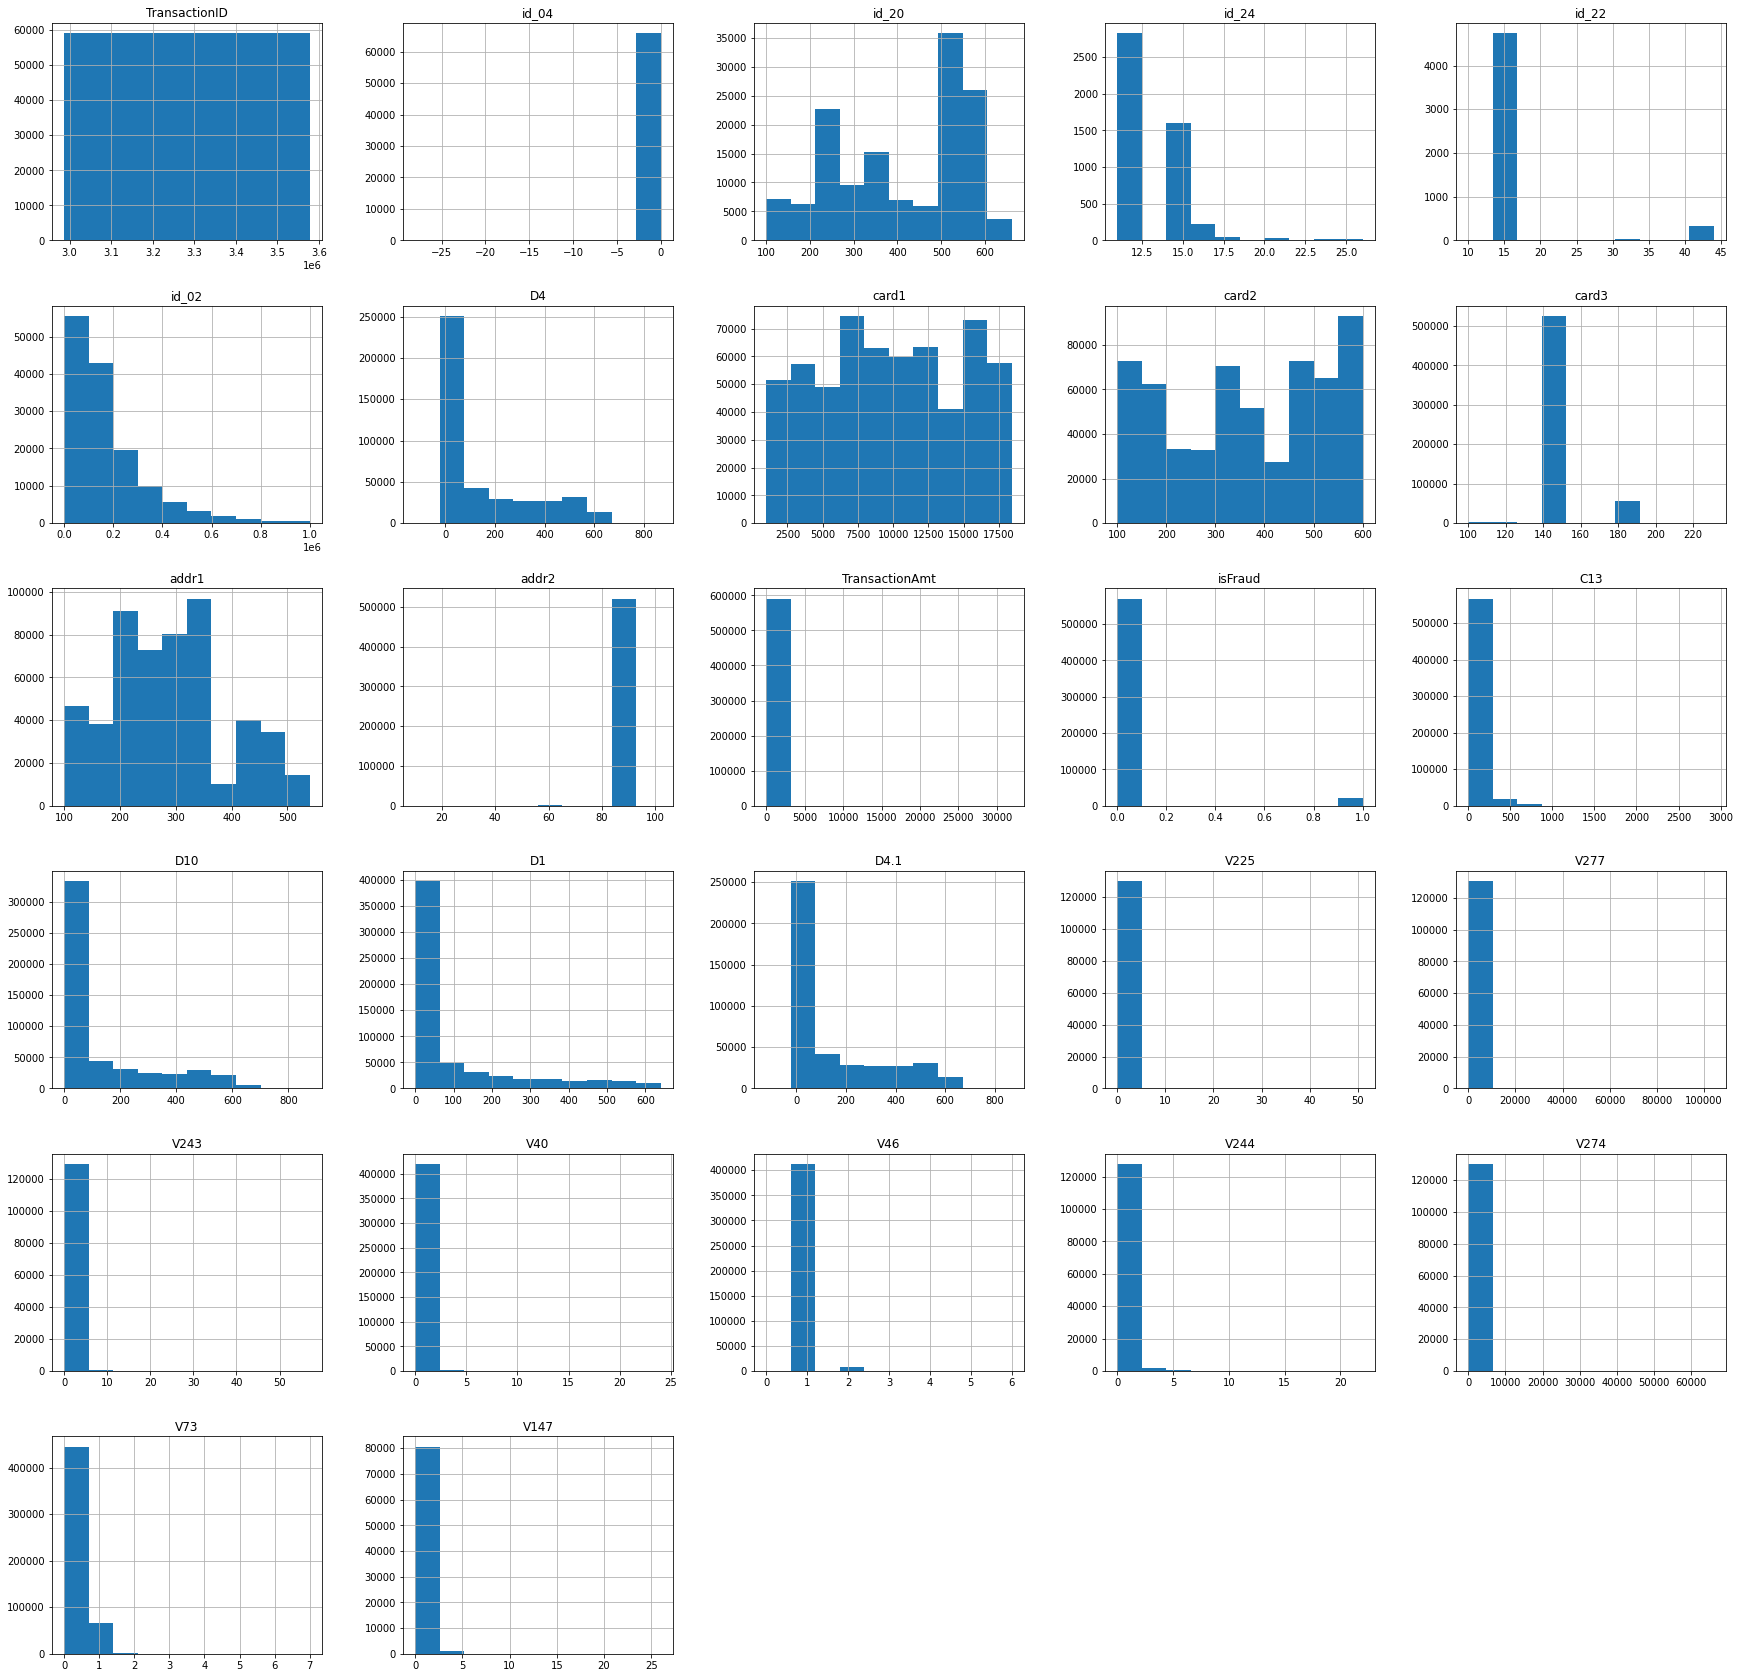

In [188]:
# Dataframe visualization
# Построим дополнительно -histogram, -pairplot для лучшего понимания структуры данных (как между собой разделяются классы). 
 
# Plot histogram
data.hist(figsize=(30,30));

In [189]:
# Plot pairwise relationships in a dataset.
#sns.pairplot(data=data, hue='isFraud');

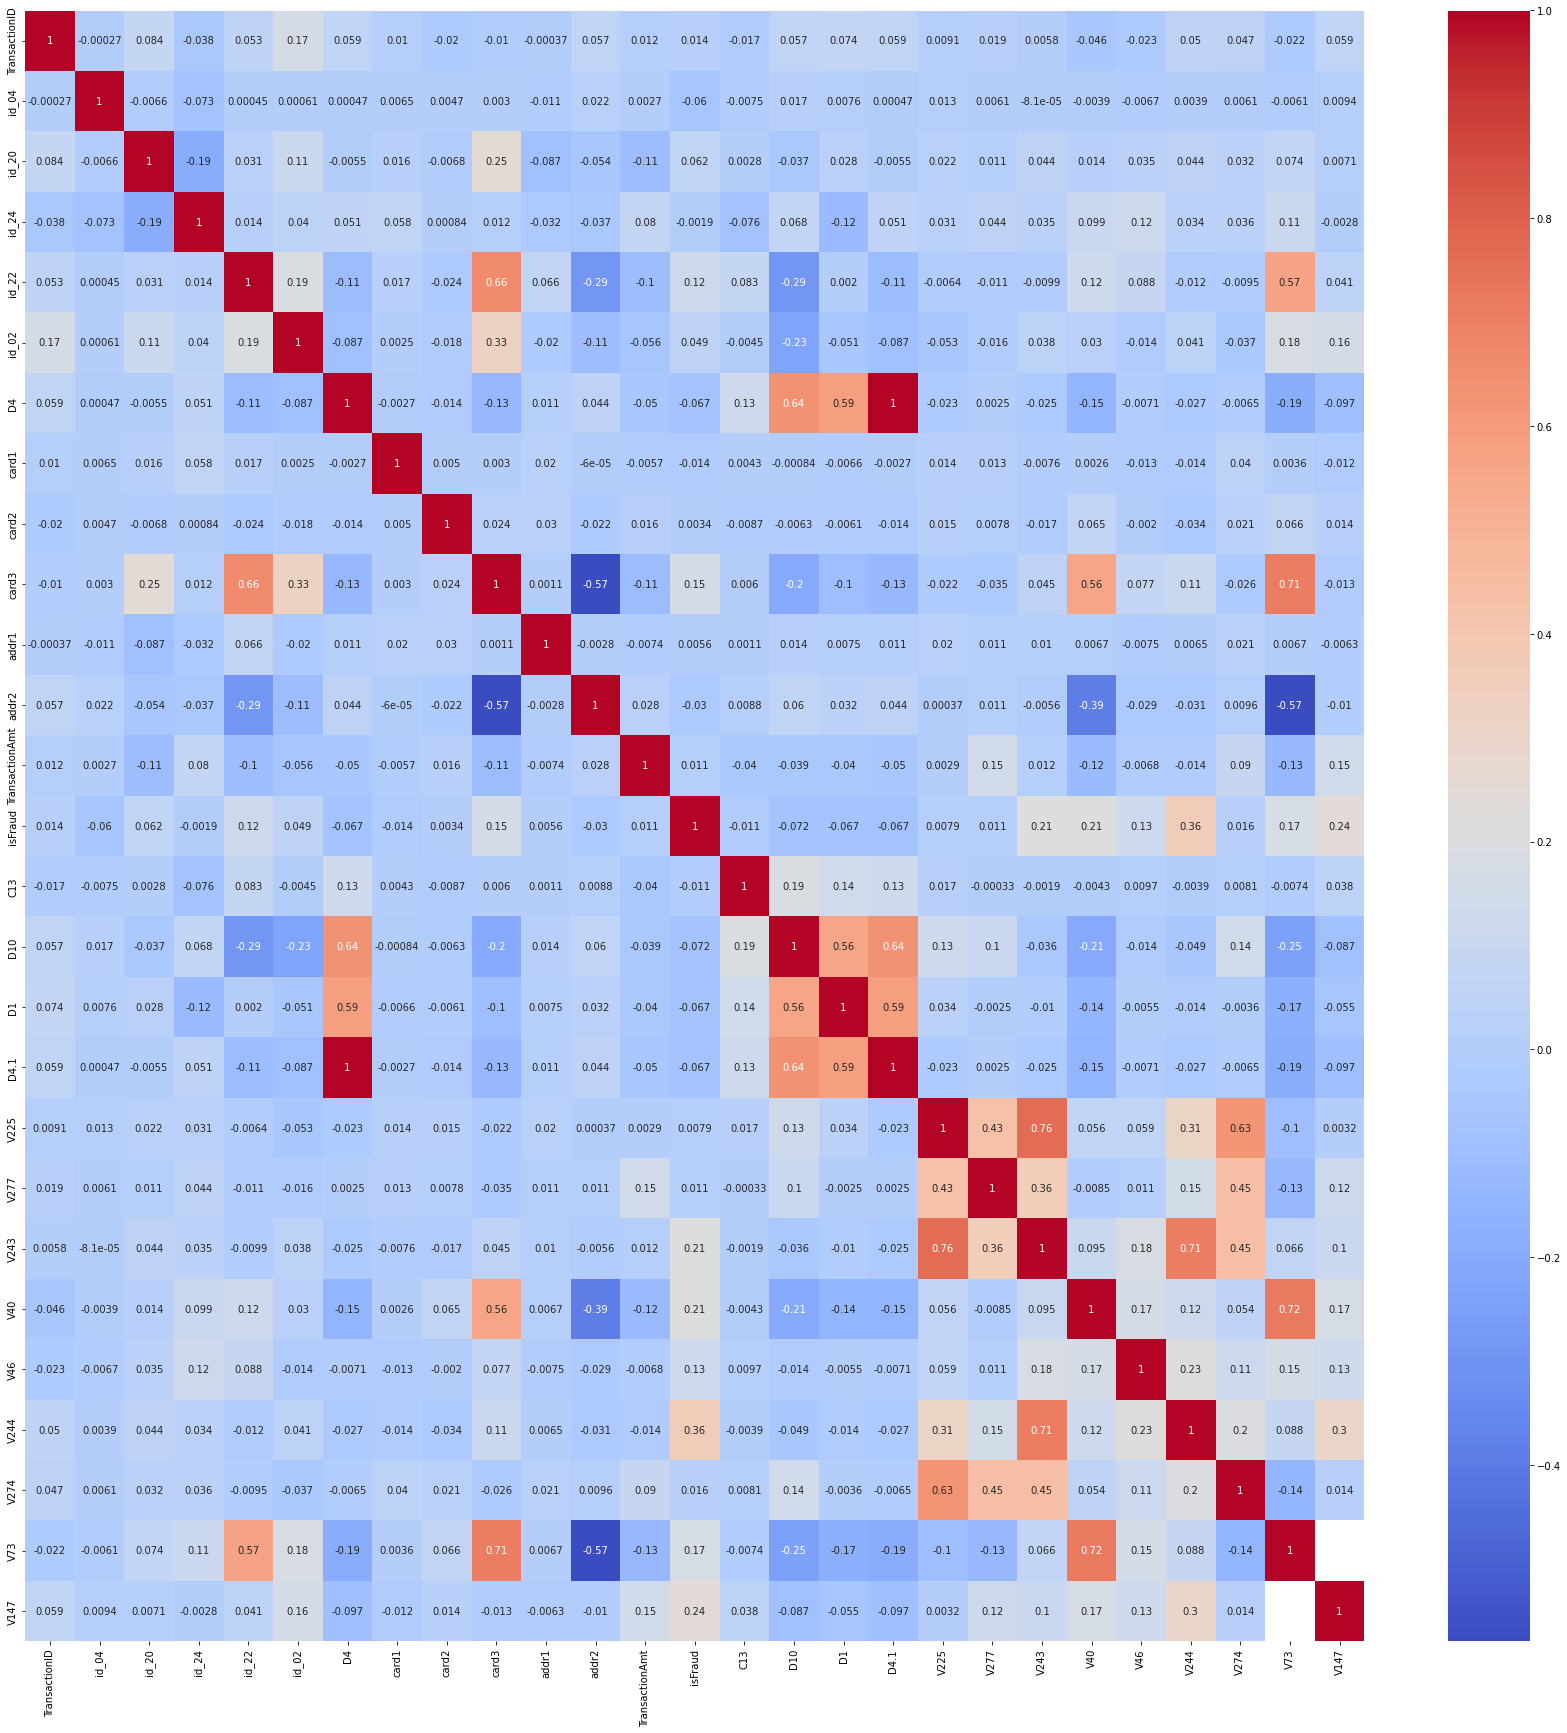

In [190]:
# Построим матрицу корреляции между признаками на исходных данных:

# Весь набор данных
plt.figure(figsize=(30,30))
#diabetes.corr()
sns.heatmap(data.corr(),annot=True, cmap="coolwarm");

0    569877
1     20663
Name: isFraud, dtype: int64 



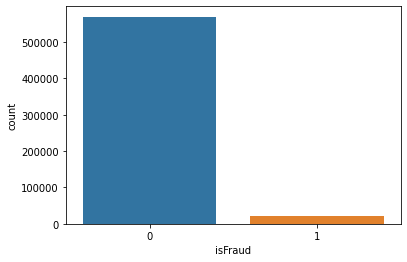

In [191]:
# Рассмотрим целевую/target переменную - 'Class'.
# Для проверки численности/балансировки классов используем функции:
#    value_counts() - для числового представления, 
#    countplot()    - для графического представления.

# Distribution of data by class, text
print(data['isFraud'].value_counts(), '\n')

# Distribution of data by class, graphic
sns.countplot(data=data, x='isFraud');

Summary of dataset:

* общее количество колонок - 30 (29 атрибутов и одна целевая переменная)
* количество сэмплов/строк – 590540
* пропущенных значении - значительное количество пропущенных значении
* все признаки - являются числовыми значениями
* целевая переменная - 'isFraud' содержит два класса: class 0 - 569877(96.5%) и class 1 - 20663(3.5%)  (Присутствует большой дисбаланс классов.)

## Categorical Data

In [192]:
# Категориальными данными являются три атрибута "id_33", "id_29", "M5" (data.dtypes)
data[["id_33", "id_29", "M5"]]

,id_33,id_29,M5
0,2220x1080,NotFound,NaN
1,1334x750,NotFound,NaN
2,NaN,Found,NaN
3,NaN,NotFound,NaN
4,1280x800,Found,NaN
...,...,...,...
590535,NaN,NaN,T
590536,NaN,NaN,F
590537,NaN,NaN,NaN
590538,NaN,NaN,F


In [193]:
# Distribution of data
print(data['id_33'].value_counts(), '\n')

1920x1080    16874
1366x768      8605
1334x750      6447
2208x1242     4900
1440x900      4384
             ...  
1536x960         1
1232x800         1
1264x924         1
1281x800         1
1280x900         1
Name: id_33, Length: 260, dtype: int64 



In [194]:
# Атрибут 'id_33' - является разрешение экрана устройств с которых подключались к сети банка, 260 уникальных значений. Удалим из набора.
data.drop('id_33', axis=1, inplace=True)

In [195]:
# Distribution of data
print(data['id_29'].value_counts(), '\n')

Found       74926
NotFound    66052
Name: id_29, dtype: int64 



In [196]:
# Distribution of data
print(data['M5'].value_counts(), '\n')

F    132491
T    107567
Name: M5, dtype: int64 



In [197]:
# Атрибут 'id_29' и 'M5' имеют по два уникальных значения (категориальные бинарные)

# Convert categorical variable into dummy/indicator variables
# drop_first=True -> Multicollinearity except
# Для категориальных бинарных значении параметр drop_first=True, иначе drop_first=False

data['id_29'] = pd.get_dummies(data["id_29"], drop_first=True)
data['M5'] = pd.get_dummies(data["M5"], drop_first=True)

In [198]:
# Data types for each attribute. Теперь все данные в наборе числовые.
print(f"Data types: \n{data.dtypes}")

Data types: 
TransactionID       int64
id_04             float64
id_20             float64
id_24             float64
id_29               uint8
id_22             float64
id_02             float64
D4                float64
card1               int64
card2             float64
card3             float64
addr1             float64
addr2             float64
TransactionAmt    float64
isFraud             int64
C13               float64
D10               float64
D1                float64
D4.1              float64
V225              float64
V277              float64
V243              float64
V40               float64
V46               float64
V244              float64
V274              float64
V73               float64
V147              float64
M5                  uint8
dtype: object


## Missing values

In [199]:
# Detect missing values.
print(f"Missing values by attribute: \n{(100/590540)*data.isnull().sum()} %")

Missing values by attribute: 
TransactionID      0.000000
id_04             88.768923
id_20             76.418024
id_24             99.196159
id_29              0.000000
id_22             99.124699
id_02             76.145223
D4                28.604667
card1              0.000000
card2              1.512683
card3              0.265012
addr1             11.126427
addr2             11.126427
TransactionAmt     0.000000
isFraud            0.000000
C13                0.000000
D10               12.873302
D1                 0.214888
D4.1              28.604667
V225              77.913435
V277              77.913435
V243              77.913435
V40               28.612626
V46               28.612626
V244              77.913435
V274              77.913435
V73               13.055170
V147              86.123717
M5                 0.000000
dtype: float64 %


In [200]:
# Атрибуты ['id_04', 'id_20', 'id_24', 'id_22', 'id_02', 'D4', 'D10', 'V225', 'V277', 'V243', 'V244', 'V274', 'V73', 'V147'] 
# имеют больше половины пропущенных значений, удалим.
data.drop(['id_04', 'id_20', 'id_24', 'id_22', 'id_02', 'D4', 'D10', 'V225', 'V277', 'V243', 'V244', 'V274', 'V73', 'V147'], axis=1, inplace=True)

In [201]:
data.columns

Index(['TransactionID', 'id_29', 'card1', 'card2', 'card3', 'addr1', 'addr2',
       'TransactionAmt', 'isFraud', 'C13', 'D1', 'D4.1', 'V40', 'V46', 'M5'],
      dtype='object')

In [202]:
# Detect missing values. Проверим повторно оствшиеся атрибуты. Заполним пропущенные значения медианой.
print(f"Missing values by attribute: \n{(100/590540)*data.isnull().sum()} %")

Missing values by attribute: 
TransactionID      0.000000
id_29              0.000000
card1              0.000000
card2              1.512683
card3              0.265012
addr1             11.126427
addr2             11.126427
TransactionAmt     0.000000
isFraud            0.000000
C13                0.000000
D1                 0.214888
D4.1              28.604667
V40               28.612626
V46               28.612626
M5                 0.000000
dtype: float64 %


In [203]:
#Заполним пропущенные значения медианой. ['TransactionID', 'id_29', 'card1', 'card2', 'card3', 'addr1', 'addr2','TransactionAmt', 'isFraud', 'C13', 'D1', 'D4.1', 'V40', 'V46', 'M5']
data.fillna(data.mean(), inplace=True)

In [204]:
data.columns

Index(['TransactionID', 'id_29', 'card1', 'card2', 'card3', 'addr1', 'addr2',
       'TransactionAmt', 'isFraud', 'C13', 'D1', 'D4.1', 'V40', 'V46', 'M5'],
      dtype='object')

In [205]:
# Detect missing values. Проверим повторно оствшиеся атрибуты.
print(f"Missing values by attribute: \n{(100/590540)*data.isnull().sum()} %")

Missing values by attribute: 
TransactionID     0.0
id_29             0.0
card1             0.0
card2             0.0
card3             0.0
addr1             0.0
addr2             0.0
TransactionAmt    0.0
isFraud           0.0
C13               0.0
D1                0.0
D4.1              0.0
V40               0.0
V46               0.0
M5                0.0
dtype: float64 %


In [206]:
#Note: Все данные являются числовыми, все пропуски заплнены, форма набора:
# Data dimensionality
print(f"Shape: \n{data.shape}")

Shape: 
(590540, 15)


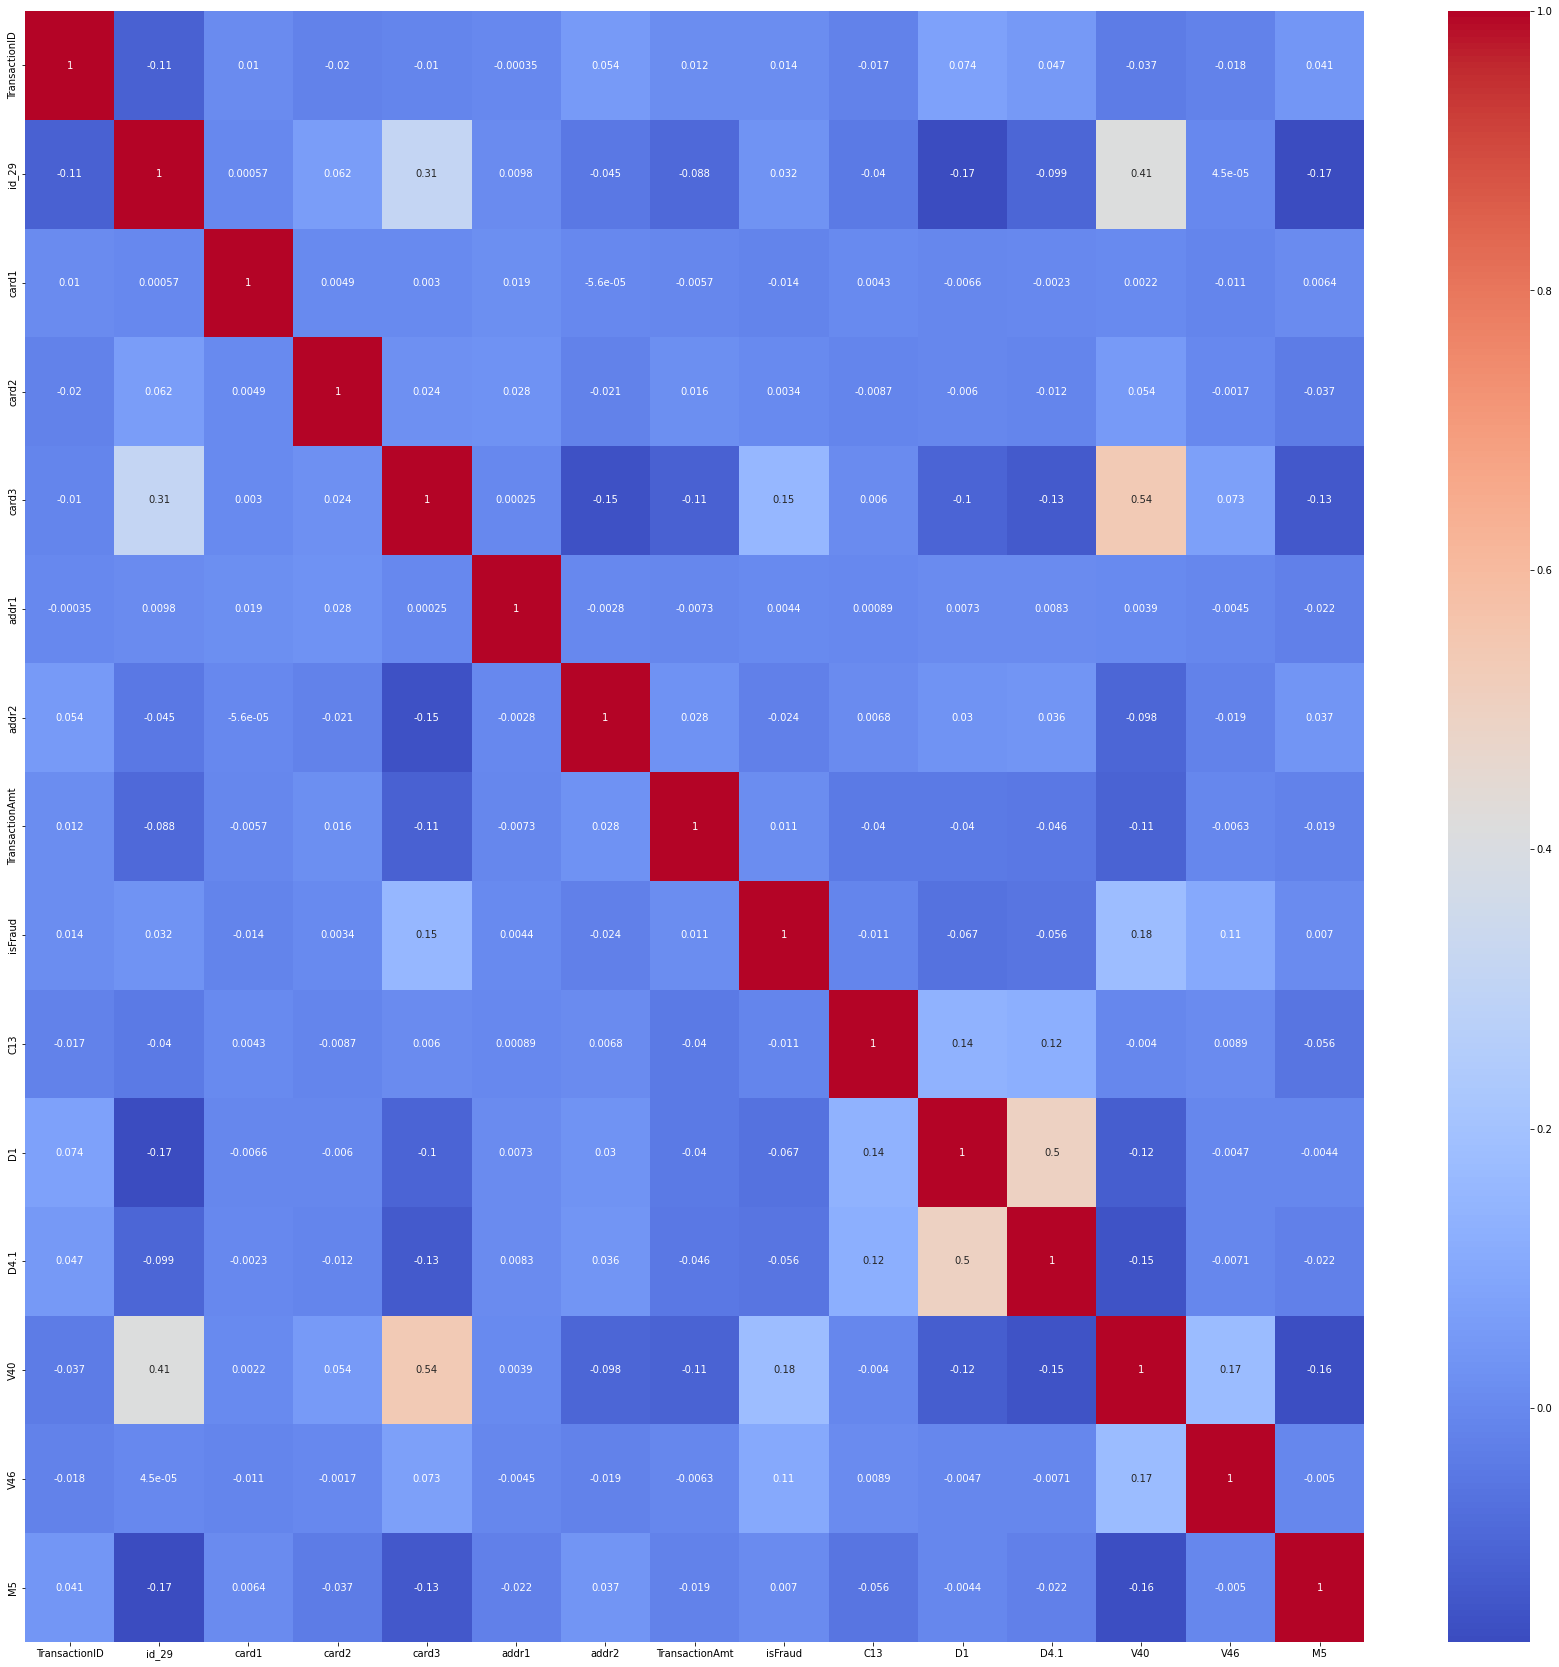

In [207]:
# Построим матрицу корреляции между признаками на обработанных данных:

# Весь набор данных
plt.figure(figsize=(30,30))
#diabetes.corr()
sns.heatmap(data.corr(),annot=True, cmap="coolwarm");

## Train Test Split + PCA

In [208]:
# inputs / Массив X, содержит признаки для обучения
X = data.drop("isFraud", axis=1)

# outputs / Массив у с целевой переменной
y = data["isFraud"]

In [209]:
# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

In [210]:
# Построим модель PCA, где количество компонент равно количеству атрибутов.
pca_base = PCA(n_components=None)
pca_base.fit(scaled_X)
X_pca_base = pca_base.transform(scaled_X)

In [211]:
# Percentage of variance explained by each of the selected components.
print("Percentage of variance: ", pca_base.explained_variance_ratio_)
print("Sum: ", np.sum(pca_base.explained_variance_ratio_))

Percentage of variance:  [0.15442477 0.10563589 0.07691285 0.07369411 0.07272532 0.07160681
 0.07033394 0.06967424 0.06861342 0.06548328 0.05852513 0.04674572
 0.03497089 0.03065363]
Sum:  1.0000000000000002


In [212]:
df_comp2 = pd.DataFrame(pca_base.components_,
                       columns=X.columns)
df_comp2

,TransactionID,id_29,card1,card2,card3,addr1,addr2,TransactionAmt,C13,D1,D4.1,V40,V46,M5
0,-0.111726,0.445199,0.002337,0.072590,0.483889,0.007559,-0.158746,-0.104860,-0.067924,-0.305998,-0.299771,0.524868,0.116161,-0.191178
1,-0.041937,-0.118605,0.004979,-0.037036,-0.216260,-0.039392,0.074716,0.244192,-0.341170,-0.566787,-0.561386,-0.214999,-0.109267,0.241417
2,-0.369189,0.155340,0.054788,0.480748,-0.154554,0.327712,-0.010510,0.319228,0.087534,-0.016913,0.035984,-0.133902,-0.383422,-0.444932
3,-0.495592,-0.045327,-0.580786,-0.134792,-0.084443,-0.461967,-0.168129,0.202698,0.193476,-0.014436,-0.000163,-0.050603,0.226374,-0.124534
4,0.426419,-0.079857,-0.193778,0.283180,0.026143,0.071959,0.252190,0.542786,-0.144430,0.061120,0.020099,0.131638,0.506217,-0.177159
5,-0.308499,-0.233947,0.253007,0.189197,-0.046207,0.371905,-0.508835,0.001537,0.026351,0.012262,-0.016255,-0.026354,0.524257,0.272537
6,-0.160807,-0.011032,0.633237,-0.357133,-0.043389,-0.168888,0.286889,0.255787,0.386332,-0.088014,-0.076925,0.022334,0.220875,-0.234834
7,0.238639,-0.079360,0.330374,0.226234,0.097296,-0.582646,-0.537467,0.257864,-0.131145,0.083769,0.052293,-0.016916,-0.206432,-0.047602
8,0.244824,-0.112981,-0.159007,-0.598053,0.100002,0.399256,-0.431588,0.280589,0.045875,-0.016411,-0.042878,-0.032063,-0.169488,-0.275636
9,0.320010,-0.187176,-0.148584,0.288366,0.055265,0.009704,-0.065308,-0.091987,0.776902,-0.190894,-0.284684,-0.015219,-0.092762,0.107490


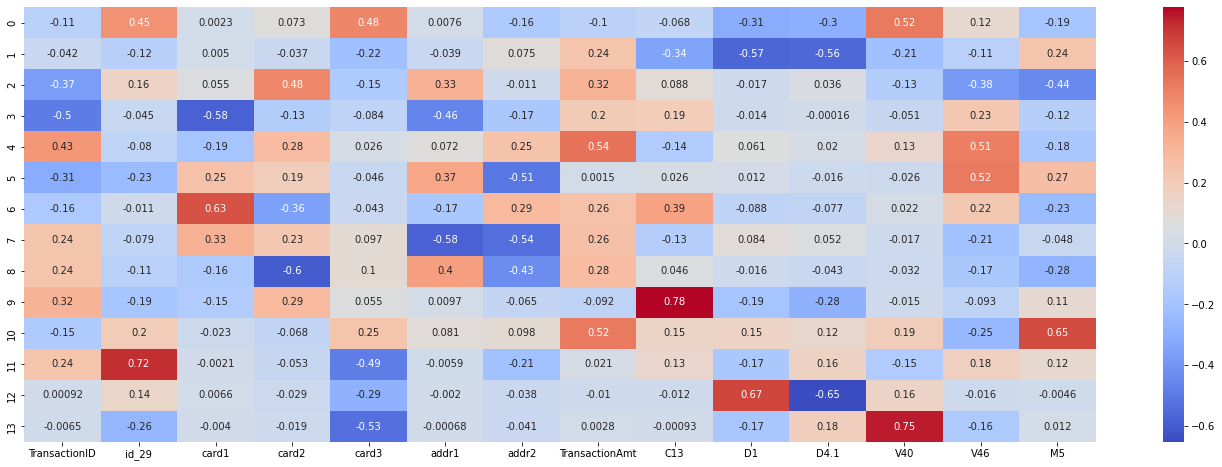

In [213]:
# Влияние атрибутов на каждую PCA компоненту
plt.figure(figsize=(24,8))
sns.heatmap(df_comp2, cmap="coolwarm", annot=True);

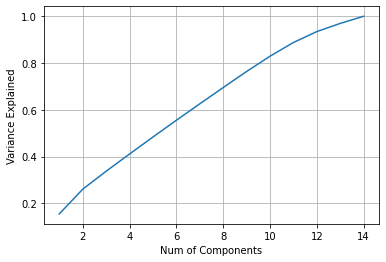

In [214]:
# Построим график изменения variance
explained_variance = []

for n in range(1, 15):
    pca = PCA(n_components=n)
    pca.fit(scaled_X)
    explained_variance.append(np.sum(pca.explained_variance_ratio_))
    
plt.plot(range(1,15), explained_variance)
plt.grid()
plt.xlabel("Num of Components")
plt.ylabel("Variance Explained");

In [215]:
# Note: В данном наборе PCA не даст выигрыша, приблизило 95% на 13 компонентах из 14. Используем далее обычную разбивку.

# Разделим данные на тестовые и обучающие, с учетом распределения классов:
test_size=0.25     # Размер тестового набора
random_state=21  

# Splitting the dataset into the Training set and Test set, stratify
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=test_size, 
                                                    random_state=random_state, 
                                                    shuffle=True, 
                                                    stratify=y)

In [216]:
# Data dimensionality and class distribution on train set
print(f"Shape X_train: \n{X_train.shape}\n")
print(f"Class distribution y_train: \n{y_train.value_counts()}")

Shape X_train: 
(442905, 14)

Class distribution y_train: 
0    427408
1     15497
Name: isFraud, dtype: int64


In [217]:
# Data dimensionality and class distribution on test set
print(f"Shape X_test: \n{X_test.shape}\n")
print(f"Class distribution y_test: \n{y_test.value_counts()}")

Shape X_test: 
(147635, 14)

Class distribution y_test: 
0    142469
1      5166
Name: isFraud, dtype: int64


In [218]:
folds = 10

# Returns K-Folds cross-validator
kf = KFold(n_splits=folds, random_state=random_state, shuffle=True)

# Returns stratified folds
skf = StratifiedKFold(n_splits=folds, random_state=random_state, shuffle=True)

# Building models

## Logistic Regression Model

In [219]:
# Build base model LogisticRegression()

# Instantiate a classifier
base_log_model = LogisticRegression()

# Train classifer
base_log_model.fit(X_train,y_train)

# Print Model parameters
print(f"Model parameters: \n{base_log_model.get_params()}", '\n')

Model parameters: 
{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False} 



In [220]:
# Model Performance

# Predict class labels for samples in X
base_log_y_pred = base_log_model.predict(X = X_test)

# Accuracy classification score
print("Accuracy classification score: \n", accuracy_score(y_test, base_log_y_pred), '\n')

# ROC Auc Score
print("ROC Auc Score: \n", roc_auc_score(y_test, base_log_y_pred), '\n')

# Build classification report
print("Classification report: \n", classification_report(y_test, base_log_y_pred), '\n')

# Build confusion matrix in text mode
print("Confusion matrix (text mode): \n", confusion_matrix(y_test, base_log_y_pred), '\n')

Accuracy classification score: 
 0.965001524028855 

ROC Auc Score: 
 0.4999964904645923 

Classification report: 
               precision    recall  f1-score   support

           0       0.97      1.00      0.98    142469
           1       0.00      0.00      0.00      5166

    accuracy                           0.97    147635
   macro avg       0.48      0.50      0.49    147635
weighted avg       0.93      0.97      0.95    147635
 

Confusion matrix (text mode): 
 [[142468      1]
 [  5166      0]] 



In [221]:
################################################################################################

In [222]:
# Build base model LogisticRegression() + class_weight='balanced'

# Instantiate a classifier
base_log_model = LogisticRegression(class_weight='balanced')

# Train classifer
base_log_model.fit(X_train,y_train)

# Print Model parameters
print(f"Model parameters: \n{base_log_model.get_params()}", '\n')

Model parameters: 
{'C': 1.0, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False} 



In [223]:
# Model Performance

# Predict class labels for samples in X
base_log_y_pred = base_log_model.predict(X = X_test)

# Accuracy classification score
print("Accuracy classification score: \n", accuracy_score(y_test, base_log_y_pred), '\n')

# ROC Auc Score
print("ROC Auc Score: \n", roc_auc_score(y_test, base_log_y_pred), '\n')

# Build classification report
print("Classification report: \n", classification_report(y_test, base_log_y_pred), '\n')

# Build confusion matrix in text mode
print("Confusion matrix (text mode): \n", confusion_matrix(y_test, base_log_y_pred), '\n')

Accuracy classification score: 
 0.4381481356047008 

ROC Auc Score: 
 0.6073087346613432 

Classification report: 
               precision    recall  f1-score   support

           0       0.98      0.43      0.59    142469
           1       0.05      0.79      0.09      5166

    accuracy                           0.44    147635
   macro avg       0.51      0.61      0.34    147635
weighted avg       0.95      0.44      0.58    147635
 

Confusion matrix (text mode): 
 [[60609 81860]
 [ 1089  4077]] 



In [224]:
# Note: С включенной балансировкой (class_weight='balanced') вырос ROC Auc Score 0.60 против 0.49. 
# Без (class_weight='balanced') не смогли предсказать ни одной мошеннической операции

In [225]:
################################################################################################

## KNeighbors Classifier Model

In [226]:
# Build model KNeighborsClassifier

for i in range(3,16,2):
    # Instantiate a classifier
    base_knn_model = KNeighborsClassifier(n_neighbors=i,n_jobs=-1)

    # Train classifer
    base_knn_model.fit(X_train,y_train)

    # Model Performance

    # Predict class labels for samples in X
    base_knn_y_pred = base_knn_model.predict(X = X_test)

    print("n_neighbors = ", i)
    # Accuracy classification score
    print("Accuracy classification score: \n", accuracy_score(y_test, base_knn_y_pred))

    # ROC Auc Score
    print("ROC Auc Score: \n", roc_auc_score(y_test, base_knn_y_pred), '\n')
    
    # Build classification report
    print("Classification report: \n", classification_report(y_test, base_log_y_pred), '\n')

n_neighbors =  3
Accuracy classification score: 
 0.9606800555423849
ROC Auc Score: 
 0.6012017626144979 

Classification report: 
               precision    recall  f1-score   support

           0       0.98      0.43      0.59    142469
           1       0.05      0.79      0.09      5166

    accuracy                           0.44    147635
   macro avg       0.51      0.61      0.34    147635
weighted avg       0.95      0.44      0.58    147635
 

n_neighbors =  5
Accuracy classification score: 
 0.9635994174823044
ROC Auc Score: 
 0.5587808362584014 

Classification report: 
               precision    recall  f1-score   support

           0       0.98      0.43      0.59    142469
           1       0.05      0.79      0.09      5166

    accuracy                           0.44    147635
   macro avg       0.51      0.61      0.34    147635
weighted avg       0.95      0.44      0.58    147635
 

n_neighbors =  7
Accuracy classification score: 
 0.964662850949978
ROC Auc Sc

In [227]:
#Note: В данных моделях лутший результат при: 
#n_neighbors =  3
#Accuracy classification score: 
# 0.9606800555423849
#ROC Auc Score: 
# 0.6012017626144979 

## XGBoost Model

In [230]:
# Build XGBoost model

# Instantiate a classifier
xgb_model = XGBClassifier()

# Train classifer
xgb_model.fit(X_train,y_train)

# Print Model parameters
print(f"Model parameters: \n{xgb_model.get_params()}", '\n')

c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:20:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model parameters: 
{'objective': 'binary:logistic', 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'enable_categorical': False, 'gamma': 0, 'gpu_id': -1, 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 100, 'n_jobs': 4, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None} 



In [231]:
# Model Performance

# Predict class labels for samples in X
xgb_y_pred = xgb_model.predict(X = X_test)

# Accuracy classification score
print("Accuracy classification score: \n", accuracy_score(y_test, xgb_y_pred), '\n')

# ROC Auc Score
print("ROC Auc Score: \n", roc_auc_score(y_test, xgb_y_pred), '\n')

# Build classification report
print("Classification report: \n", classification_report(y_test, xgb_y_pred), '\n')

# Build confusion matrix in text mode
print("Confusion matrix (text mode): \n", confusion_matrix(y_test, xgb_y_pred), '\n')

Accuracy classification score: 
 0.9717682121448166 

ROC Auc Score: 
 0.6201922269146735 

Classification report: 
               precision    recall  f1-score   support

           0       0.97      1.00      0.99    142469
           1       0.83      0.24      0.38      5166

    accuracy                           0.97    147635
   macro avg       0.90      0.62      0.68    147635
weighted avg       0.97      0.97      0.96    147635
 

Confusion matrix (text mode): 
 [[142216    253]
 [  3915   1251]] 



In [250]:
# Build XGBoost model + class_weight

# Оценка весов выборки по классам для несбалансированных наборов данных.
#classes_weights = class_weight.compute_sample_weight(class_weight='balanced',y=y_train)
#print("Shape weights: ", classes_weights.shape, '\n')

#scale_pos_weight [default=1]
#Control the balance of positive and negative weights, useful for unbalanced classes. 
# A typical value to consider: sum(negative instances) / sum(positive instances).

# Distribution of data by class, text
print(data['isFraud'].value_counts(), '\n')
scale_pos_weight = data['isFraud'].value_counts()[0]/data['isFraud'].value_counts()[1]

0    569877
1     20663
Name: isFraud, dtype: int64 



In [251]:
# Instantiate a classifier
#xgb_model = XGBClassifier(sample_weight=sample_weights)
xgb_model = XGBClassifier(scale_pos_weight=scale_pos_weight)

# Train classifer
xgb_model.fit(X_train,y_train)

# Print Model parameters
print(f"Model parameters: \n{xgb_model.get_params()}", '\n')

c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:45:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model parameters: 
{'objective': 'binary:logistic', 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'enable_categorical': False, 'gamma': 0, 'gpu_id': -1, 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 100, 'n_jobs': 4, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 27.579586700866283, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None

In [249]:
# Model Performance

# Predict class labels for samples in X
xgb_y_pred = xgb_model.predict(X = X_test)

# Accuracy classification score
print("Accuracy classification score: \n", accuracy_score(y_test, xgb_y_pred), '\n')

# ROC Auc Score
print("ROC Auc Score: \n", roc_auc_score(y_test, xgb_y_pred), '\n')

# Build classification report
print("Classification report: \n", classification_report(y_test, xgb_y_pred), '\n')

# Build confusion matrix in text mode
print("Confusion matrix (text mode): \n", confusion_matrix(y_test, xgb_y_pred), '\n')

Accuracy classification score: 
 0.8691434957835201 

ROC Auc Score: 
 0.8336986184960472 

Classification report: 
               precision    recall  f1-score   support

           0       0.99      0.87      0.93    142469
           1       0.18      0.80      0.30      5166

    accuracy                           0.87    147635
   macro avg       0.59      0.83      0.61    147635
weighted avg       0.96      0.87      0.91    147635
 

Confusion matrix (text mode): 
 [[124206  18263]
 [  1056   4110]] 



In [252]:
# Note: Увеличилось ROC Auc Score: 0.83 против 0.62, 
# но ухудшилось точность предсказание мошеннической операции 0.18 против 0.83

## Random Under Sampler

In [253]:
# Класс для проведения случайной заниженной выборки.
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(scaled_X, y)

# Data dimensionality
print(f"Scaled_X: \n{scaled_X.shape}")

# Data dimensionality
print(f"Shape X_res: \n{X_res.shape}")

Scaled_X: 
(590540, 14)
Shape X_res: 
(41326, 14)


In [254]:
# Разделим данные на тестовые и обучающие, с учетом распределения классов:
test_size=0.25     # Размер тестового набора
random_state=21  

# Splitting the dataset into the Training set and Test set, stratify
X_train, X_test, y_train, y_test = train_test_split(X_res, 
                                                    y_res, 
                                                    test_size=test_size, 
                                                    random_state=random_state, 
                                                    shuffle=True)

In [255]:
# Data dimensionality and class distribution on train set
print(f"Shape X_train: \n{X_train.shape}\n")
print(f"Class distribution y_train: \n{y_train.value_counts()}", '\n')

# Data dimensionality and class distribution on test set
print(f"Shape X_test: \n{X_test.shape}\n")
print(f"Class distribution y_test: \n{y_test.value_counts()}")

Shape X_train: 
(30994, 14)

Class distribution y_train: 
0    15567
1    15427
Name: isFraud, dtype: int64 

Shape X_test: 
(10332, 14)

Class distribution y_test: 
1    5236
0    5096
Name: isFraud, dtype: int64


In [256]:
# Build base model LogisticRegression()

# Instantiate a classifier
res_log_model = LogisticRegression()

# Train classifer
res_log_model.fit(X_train,y_train)

# Print Model parameters
print(f"Model parameters: \n{res_log_model.get_params()}", '\n')

Model parameters: 
{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False} 



In [257]:
# Model Performance

# Predict class labels for samples in X
res_log_y_pred = res_log_model.predict(X = X_test)

# Accuracy classification score
print("Accuracy classification score: \n", accuracy_score(y_test, res_log_y_pred), '\n')

# ROC Auc Score
print("ROC Auc Score: \n", roc_auc_score(y_test, res_log_y_pred), '\n')

# Build classification report
print("Classification report: \n", classification_report(y_test, res_log_y_pred), '\n')

# Build confusion matrix in text mode
print("Confusion matrix (text mode): \n", confusion_matrix(y_test, res_log_y_pred), '\n')

Accuracy classification score: 
 0.6691831204026326 

ROC Auc Score: 
 0.6702766771044082 

Classification report: 
               precision    recall  f1-score   support

           0       0.64      0.75      0.69      5096
           1       0.71      0.59      0.64      5236

    accuracy                           0.67     10332
   macro avg       0.67      0.67      0.67     10332
weighted avg       0.67      0.67      0.67     10332
 

Confusion matrix (text mode): 
 [[3827 1269]
 [2149 3087]] 



In [258]:
# Note: При помощи RandomUnderSampler в LogisticRegression значиельно увеличилась точность 
# предсказание мошеннической операции 0.71 против 0.05 (с включенной балансировкой)

# Summary:

В данной работе были использованы модели Logistic Regression Model, KNeighbors Classifier Model, XGBoost Model для решения задачи предсказания мошеннических операции / fraudulent transactions на несбалансированном дата сете. Так были дополнительно использованы методы балансировки классов такие как RandomUnderSampler.

In [259]:
################################################################################################